## RNN의 문제점

- 시계열 데이터에서 멀리 떨어진, 장기(long term) 의존 관계를 잘 학습할 수 없음
    - BPTT에서 기울기 소실/폭발이 일어나기 때문
<br/> <img src='../figs/fig%206-3.png'> <br/>
- '?'에 들어가는 단어는 'Tom'  
RNNLM이 위 질문에 답하기 위해서는 'Tom이 방에서 TV를 보고 있음'과 'Mary가 방에 들어옴'이라는 두 정보를 모두 기억해야 함.  
<br/> <img src='../figs/fig%206-4.png'> <br/>
위 그림에서 빨간색 화살표를 따라 기울기를 전달하여 학습하는데, 단어간의 거리가 멀어지면(long-term) 결국 기울기가 작아지거나(소실), 커져서(폭발) 장기 의존 관계를 학습할 수 없게 됨.  
<br/>
- 기울기 소실(vanishing gradient)이 일어나는 이유
    - $y = tanh(x)$의 미분은 ${\partial y \over \partial x} = 1 - y^2$으로 역전파 과정에서 기울기가 tanh 노드를 지날때마다 작아짐
- 기울기 폭발(exploding gradients)
    - Matrix multiplication을 실행하면서 시간에 따라 
    - Wh의 singular value의 최댓값이 1보다 큰 경우 : 기울기가 exponentially 증가
    - 1보다 작은 경우: 기울기가 exponentially 감소(이 경우 vanishing gradient)  
[30] 'On the difficulty of training recurrent neural networks'

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

# Vanishing gradients
dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []

for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

plt.plot(norm_list)

findfont: Font family ['D2Coding ligature'] not found. Falling back to DejaVu Sans.


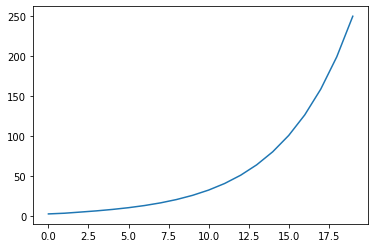

In [2]:
# Exploding gradients
dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []

for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

plt.plot(norm_list)

### gradient clipping

- 기울기 폭발의 해결방법 중 하나.  
$if~~\| \hat g \| \geq theshold~:~~~ \hat g = {threshold \over \| \hat g \|} \hat g $  
- 기울기 g가 일정 값(threshold) 이상으로 커지면 기울기를 수정해 주는 것.

In [3]:
def clip_grads(grads, max_norm):
    total_norm = 0
    # g hat 계산
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [4]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

print(grads)
clip_grads(grads, max_norm)
print(grads)

[array([[6.49144048, 2.78487283, 6.76254902],
       [5.90862817, 0.23981882, 5.58854088],
       [2.59252447, 4.15101197, 2.83525082]]), array([[6.93137918, 4.40453718, 1.56867738],
       [5.44649018, 7.80314765, 3.06363532],
       [2.21957884, 3.87971258, 9.3638365 ]])]
[array([[1.49503731, 0.64138134, 1.55747605],
       [1.36081038, 0.05523244, 1.28709139],
       [0.59708178, 0.95601551, 0.65298384]]), array([[1.59635916, 1.01440465, 0.36128056],
       [1.25437583, 1.79713531, 0.70558286],
       [0.51118903, 0.89353281, 2.15657603]])]


## LSTM

- 이제 vanishing gradient를 해결하기 위해서 '게이트가 추가된 RNN'을 도입할 것  
대표적으로 LSTM, GRU가 있고, LSTM을 먼저 다룰 것임  
<br/> <img src='../figs/fig%206-15.png' width='300px'> <br/>
- LSTM에는 기존 RNN과 다르게 기억 셀(memory cell) $c$라는 경로가 있음  
    - $c_t$에는 시각 $t$에서의 LSTM의 기억이 저장되어 있음  
    이 $c_t$를 통해 $h_t=tanh(c_t)$를 계산  
    
#### output gate의 열림 상태
$o = \sigma(x_{t} W_{x}^{(o)} + h_{t-1}W_{h}^{(o)} + b^{(o)})$
    - $tanh(c_t)$의 원소들에 대해 '그것이 다음 시각의 hidden state에 얼마나 중요한가'를 조정  
    - 여기서 $\sigma$(sigmoid)의 출력은 0~1로 데이터를 얼마만큼 통과시킬지를 정하는 비율  
    
#### output gate    
$h_{t} = o \circ tanh(c_{t})$
    - 여기서 tanh의 출력은 -1.0~1.0으로 '정보'의 강약(정도)를 표시한다고 볼 수 있음  
    - 정보를 얼마만큼 통과시킬지 정하는 sigmoid와 다르게 실질적인 '정보'를 지니는 데이터에는 tanh를 주로 사용
    
#### forget gate
<img src='../figs/fig%206-16.png' width='300px'> <br/>
- $c_{t-1}$의 기억 중 불필요한 기억을 잊게 해주는 게이트  
    - $f = \sigma(x_{t} W_{x}^{(f)} + h_{t-1}W_{h}^{(f)} + b^{(f)})$   
    - $c_{t} = f \circ c_{t-1}$

#### 새로운 기억 셀
<img src='../figs/fig%206-17.png' width='300px'> <br/>
- 새로 기억해야 할 정보를 기억 셀 $c$에 추가    
    - $g = \tanh(x_{t} W_{x}^{(g)} + h_{t-1}W_{h}^{(g)} + b^{(g)})$   
    - 잊어버릴 정보가 아니라 실질적으로 '기억'해야할 정보기 때문에 $sigmoid$가 아닌 $tanh$ 사용
    
#### input gate
<img src='../figs/fig%206-18.png' width='300px'> <br/>   
- 위의 $g$로 새로 추가되는 정보가 얼마나 가치있는 정보인지 판단하기 위해 input gate로 가중치를 줌
    - $i = \sigma(x_{t} W_{x}^{(i)} + h_{t-1}W_{h}^{(i)} + b^{(i)})$   
    - 이후 $i$와 $g$의 원소별 곱을 기억 셀 $c$에 추가

### LSTM의 기울기 흐름

- 기억 셀 c의 역전파 흐름을 보면 $+$와 $\times$ 노드를 지남  
- $+$ 노드를 지날때는 기울기 변화가 일어나지 않음
- $\times$ 노드의 경우 matrix multiplication이 아닌 hadamard product(elementwise)를 계산하기 때문에 기울기 소실이 일어나기 어려움
- 특히 $\times$ 연산을 제어하는 forget gate가 잊어야할 정보와 잊어서는 안될 정보를 판단해주기 때문에 '오래 기억해야 할 정보'의 경우 기울기가 소실 없이 전파될 것을 기대할 수 있음

<br/> <img src='../figs/fig%206-19.png'> <br/>

## 구현

- 아래 네가지 게이트에서 일어나는 계산들은 $W$만 다를 뿐 같은 계산을 수행함.(Affine transformation)
- 4개의 가중치 $W$를 하나로 모아서 한번의 affine transformation만 수행할것임.
<br/> <img src='../figs/e%206-6.png'> <br/>

In [9]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        # ?
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next **2)
        
        dc_prev = ds * f
        df = ds * c_prev
        dg = ds * i
        di = ds * g
        do = dh_next * tanh_c_next
        
        df *= f * (1 - f)
        dg *= (1 - g**2)
        di *= i * (1 - i)
        do *= o * (1 - o)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

### Time LSTM

- T개의 시계열 데이터를 한꺼번에 처리하는 T개의 LSTM layer

In [10]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
            
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype = 'f')
            
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
            
        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh, dc = 0, 0
        grads = [0, 0, 0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
            
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        self.dh = dh
        return dxs
    
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None
            
        
        
    

## LSTM을 사용한 RNNLM

In [11]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel
import pickle

class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

In [5]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from data import ptb

In [6]:
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

In [7]:
# load dataa
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

Done


In [12]:
# model 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

In [13]:
# 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval = 20)

| current_epoch 1 |  iters 1 / 1327 | time 1.0497894287109375[s] | perplexity 9999.937519272651
| current_epoch 1 |  iters 21 / 1327 | time 16.190855026245117[s] | perplexity 2821.480384443953
| current_epoch 1 |  iters 41 / 1327 | time 31.35884690284729[s] | perplexity 1261.3791155142342
| current_epoch 1 |  iters 61 / 1327 | time 46.12487435340881[s] | perplexity 968.5359917598987
| current_epoch 1 |  iters 81 / 1327 | time 61.4105429649353[s] | perplexity 809.3184328795666
| current_epoch 1 |  iters 101 / 1327 | time 76.20887470245361[s] | perplexity 657.2590707034198
| current_epoch 1 |  iters 121 / 1327 | time 90.92674732208252[s] | perplexity 640.8644772385672
| current_epoch 1 |  iters 141 / 1327 | time 105.86041116714478[s] | perplexity 593.6969690010263
| current_epoch 1 |  iters 161 / 1327 | time 120.71081781387329[s] | perplexity 588.6734507433605
| current_epoch 1 |  iters 181 / 1327 | time 135.8206696510315[s] | perplexity 595.1390829806868
| current_epoch 1 |  iters 201 /

| current_epoch 2 |  iters 341 / 1327 | time 1220.8142204284668[s] | perplexity 169.47538776585296
| current_epoch 2 |  iters 361 / 1327 | time 1234.936152458191[s] | perplexity 196.30589708538128
| current_epoch 2 |  iters 381 / 1327 | time 1249.3209879398346[s] | perplexity 154.30094054493532
| current_epoch 2 |  iters 401 / 1327 | time 1263.000112771988[s] | perplexity 169.16642680151978
| current_epoch 2 |  iters 421 / 1327 | time 1276.084806919098[s] | perplexity 155.90778617221903
| current_epoch 2 |  iters 441 / 1327 | time 1289.724829673767[s] | perplexity 163.83632357521424
| current_epoch 2 |  iters 461 / 1327 | time 1305.1299090385437[s] | perplexity 158.61430470668404
| current_epoch 2 |  iters 481 / 1327 | time 1320.1514685153961[s] | perplexity 156.22970506214665
| current_epoch 2 |  iters 501 / 1327 | time 1334.6755497455597[s] | perplexity 170.0902102124822
| current_epoch 2 |  iters 521 / 1327 | time 1347.9770398139954[s] | perplexity 172.15322788177562
| current_epoch

| current_epoch 3 |  iters 681 / 1327 | time 2398.1010732650757[s] | perplexity 100.68859017005968
| current_epoch 3 |  iters 701 / 1327 | time 2412.2220873832703[s] | perplexity 118.86891453581515
| current_epoch 3 |  iters 721 / 1327 | time 2426.3723294734955[s] | perplexity 127.21169536571037
| current_epoch 3 |  iters 741 / 1327 | time 2440.3461108207703[s] | perplexity 107.95300113461997
| current_epoch 3 |  iters 761 / 1327 | time 2454.7411892414093[s] | perplexity 102.79511452809383
| current_epoch 3 |  iters 781 / 1327 | time 2469.159231901169[s] | perplexity 103.83580576014567
| current_epoch 3 |  iters 801 / 1327 | time 2483.497020483017[s] | perplexity 115.1315700198485
| current_epoch 3 |  iters 821 / 1327 | time 2497.822228193283[s] | perplexity 117.18348647093539
| current_epoch 3 |  iters 841 / 1327 | time 2512.0748360157013[s] | perplexity 114.35833715082424
| current_epoch 3 |  iters 861 / 1327 | time 2525.8747079372406[s] | perplexity 120.39143118353644
| current_epoc

| current_epoch 4 |  iters 1021 / 1327 | time 3558.318479537964[s] | perplexity 113.77476778281768
| current_epoch 4 |  iters 1041 / 1327 | time 3572.791589975357[s] | perplexity 103.23500094688043
| current_epoch 4 |  iters 1061 / 1327 | time 3586.9391963481903[s] | perplexity 89.09517676607504
| current_epoch 4 |  iters 1081 / 1327 | time 3601.4410490989685[s] | perplexity 78.54961542394082
| current_epoch 4 |  iters 1101 / 1327 | time 3615.712247610092[s] | perplexity 78.4068700212461
| current_epoch 4 |  iters 1121 / 1327 | time 3627.844604253769[s] | perplexity 103.89300326899179
| current_epoch 4 |  iters 1141 / 1327 | time 3642.154410123825[s] | perplexity 99.76210828408028
| current_epoch 4 |  iters 1161 / 1327 | time 3656.5988080501556[s] | perplexity 91.94012874392234
| current_epoch 4 |  iters 1181 / 1327 | time 3671.083649158478[s] | perplexity 96.244652692072
| current_epoch 4 |  iters 1201 / 1327 | time 3685.6688933372498[s] | perplexity 83.14993472565286
| current_epoch 

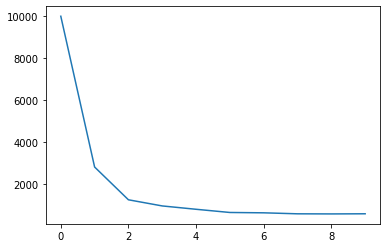

In [21]:
plt.plot(trainer.ppl_list[:10])

plt.plot(trainer.ppl_list[10:])

In [22]:
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)

evaluating perplexity ...
234 / 235


In [23]:
print('test perplexity', ppl_test)

test perplexity 135.6399667974982


In [24]:
model.save_params()

## RNNLM 개선

- 위의 RNNLM을 크게 3가지 방법을 통해 개선할 예정.
    1. LSTM 계층의 다층화
    2. dropout
    3. 가중치 공유
    

### LSTM 계층의 다층화
- LSTM layer를 여러 겹 쌓아서 모델의 정확도가 향상될 것을 기대.
    - PTB dataset의 언어 모델에서는 보통 2~4층에서 좋은 결과를 얻었음

### Dropout
- Dropout을 통해 overfitting 방지
    - 이떄 시계열 방향으로 dropout을 넣으면 시간의 흐름에 따라 정보가 사라질 수 있음
    - 대신 layer 깊이 방향으로 dropout을 적용
- Variational Dropout : 같은 layer에 속한 dropout들끼리 mask를 공유하여 dropout을 시간 방향으로 적용.
<br/> <img src='../figs/fig%206-34.png'> <br/>

### 가중치 공유(Weight tying)
- Embedding layer와 Affine layer가 가중치를 공유함으로써 학습해야하는 parameter 수가 크게 줄어들고(계산량 감소 및 overfitting도 방지), 정확도도 향상
<br/> <img src='../figs/fig%206-35.png'> <br/>


### 구현

In [4]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D)/100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(D, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_fig = train_fig
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts,  ustrain_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()
        